In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import random
import pywt
import seaborn as sns
import os
import torchvision
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys
sys.path.append('..')

from src.diffusion import UNet, Diffusion
from src.preprocessing import WaveletDetrendingPipeline, visualize_detrending_effect
# If you use statsmodels in other cells:
# from statsmodels.tsa.stattools import acf


In [39]:
# Download stock data and prepare all datasets for analysis
# This cell creates all variables needed for subsequent visualization and analysis

import yfinance as yf
import pandas as pd
import numpy as np

# CONFIGURABLE PARAMETERS
WINDOW_LENGTH = 256  # Time series window length (must be power of 2)
STRIDE = 1 # Stride for sliding window (1 = maximum overlap, WINDOW_LENGTH = no overlap)

# Download data for multiple tickers
tickers = ['GOOG', 'AAPL', 'META', 'MSFT', 'AMZN']
start_date = '2013-01-01'
end_date = '2024-12-31'

# Data structures to store results
ticker_info = []
ticker_log_volumes = {}  # Store full log volume series per ticker
ticker_zscore_volumes = {}  # Store full z-score normalized series per ticker
ticker_windows = {}  # Store log volume windows per ticker
ticker_windows_global_zscore = {}  # Store z-score normalized windows per ticker

# Step 1: Download data and apply log transform
for ticker in tickers:
    data = yf.download(ticker, interval='1d', start=start_date, end=end_date, auto_adjust=True, progress=False)
    
    # Select only Volume column
    volume_data = data[['Volume']].copy()
    volume_data.index.name = 'date'
    
    # Apply log transform to Volume
    log_volume = np.log1p(volume_data['Volume'].values)
    
    # Store full log volume series
    ticker_log_volumes[ticker] = log_volume
    
    # Store metadata
    ticker_info.append({
        'ticker': ticker,
        'length': len(log_volume),
        'log_volume': log_volume
    })

# Step 2: Apply global z-score normalization (after log transform)
for ticker in tickers:
    log_volume = ticker_log_volumes[ticker]
    
    # Apply global z-score normalization to entire time series
    mean_global = log_volume.mean()
    std_global = log_volume.std()
    
    log_volume_zscore = (log_volume - mean_global) / std_global
    
    # Clip z-scores to [-6, 6] to remove extreme outliers
    log_volume_zscore = np.clip(log_volume_zscore, -6, 6)
    
    # Store full z-score normalized series
    ticker_zscore_volumes[ticker] = log_volume_zscore

# Step 3: Create windowed datasets (sliding window with stride=1)
all_volume_series = []  # All log volume windows concatenated
all_zscore_series = []  # All z-score windows concatenated

for ticker in tickers:
    log_volume = ticker_log_volumes[ticker]
    log_volume_zscore = ticker_zscore_volumes[ticker]
    
    # Create log volume windows
    ticker_series = []
    for i in range(0, len(log_volume) - WINDOW_LENGTH + 1, STRIDE):
        window = log_volume[i:i + WINDOW_LENGTH]
        ticker_series.append(window)
    ticker_series = np.array(ticker_series, dtype=np.float32)
    ticker_windows[ticker] = ticker_series
    all_volume_series.append(ticker_series)
    
    # Create z-score normalized windows
    ticker_series_zscore = []
    for i in range(0, len(log_volume_zscore) - WINDOW_LENGTH + 1, STRIDE):
        window = log_volume_zscore[i:i + WINDOW_LENGTH]
        ticker_series_zscore.append(window)
    ticker_series_zscore = np.array(ticker_series_zscore, dtype=np.float32)
    ticker_windows_global_zscore[ticker] = ticker_series_zscore
    all_zscore_series.append(ticker_series_zscore)

# Step 4: Concatenate all windows across tickers
volume_series = np.concatenate(all_volume_series, axis=0)  # All log volume windows
all_windows_combined = np.concatenate(all_zscore_series, axis=0)  # All z-score windows



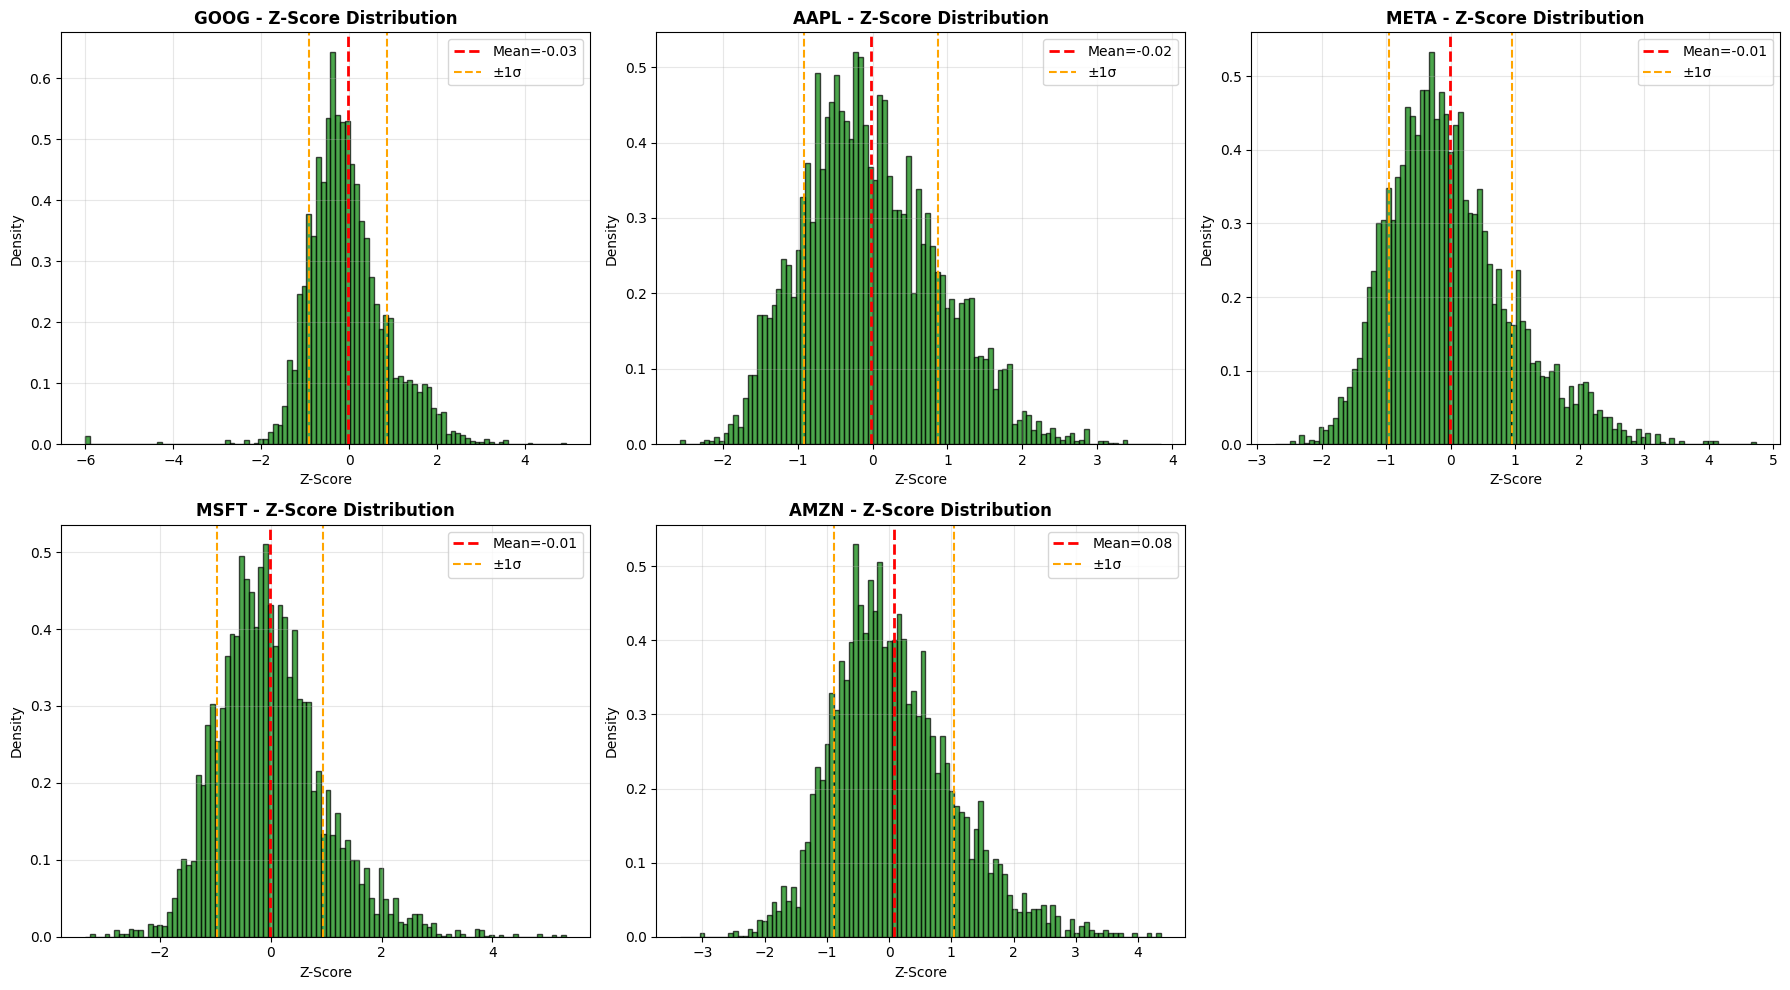

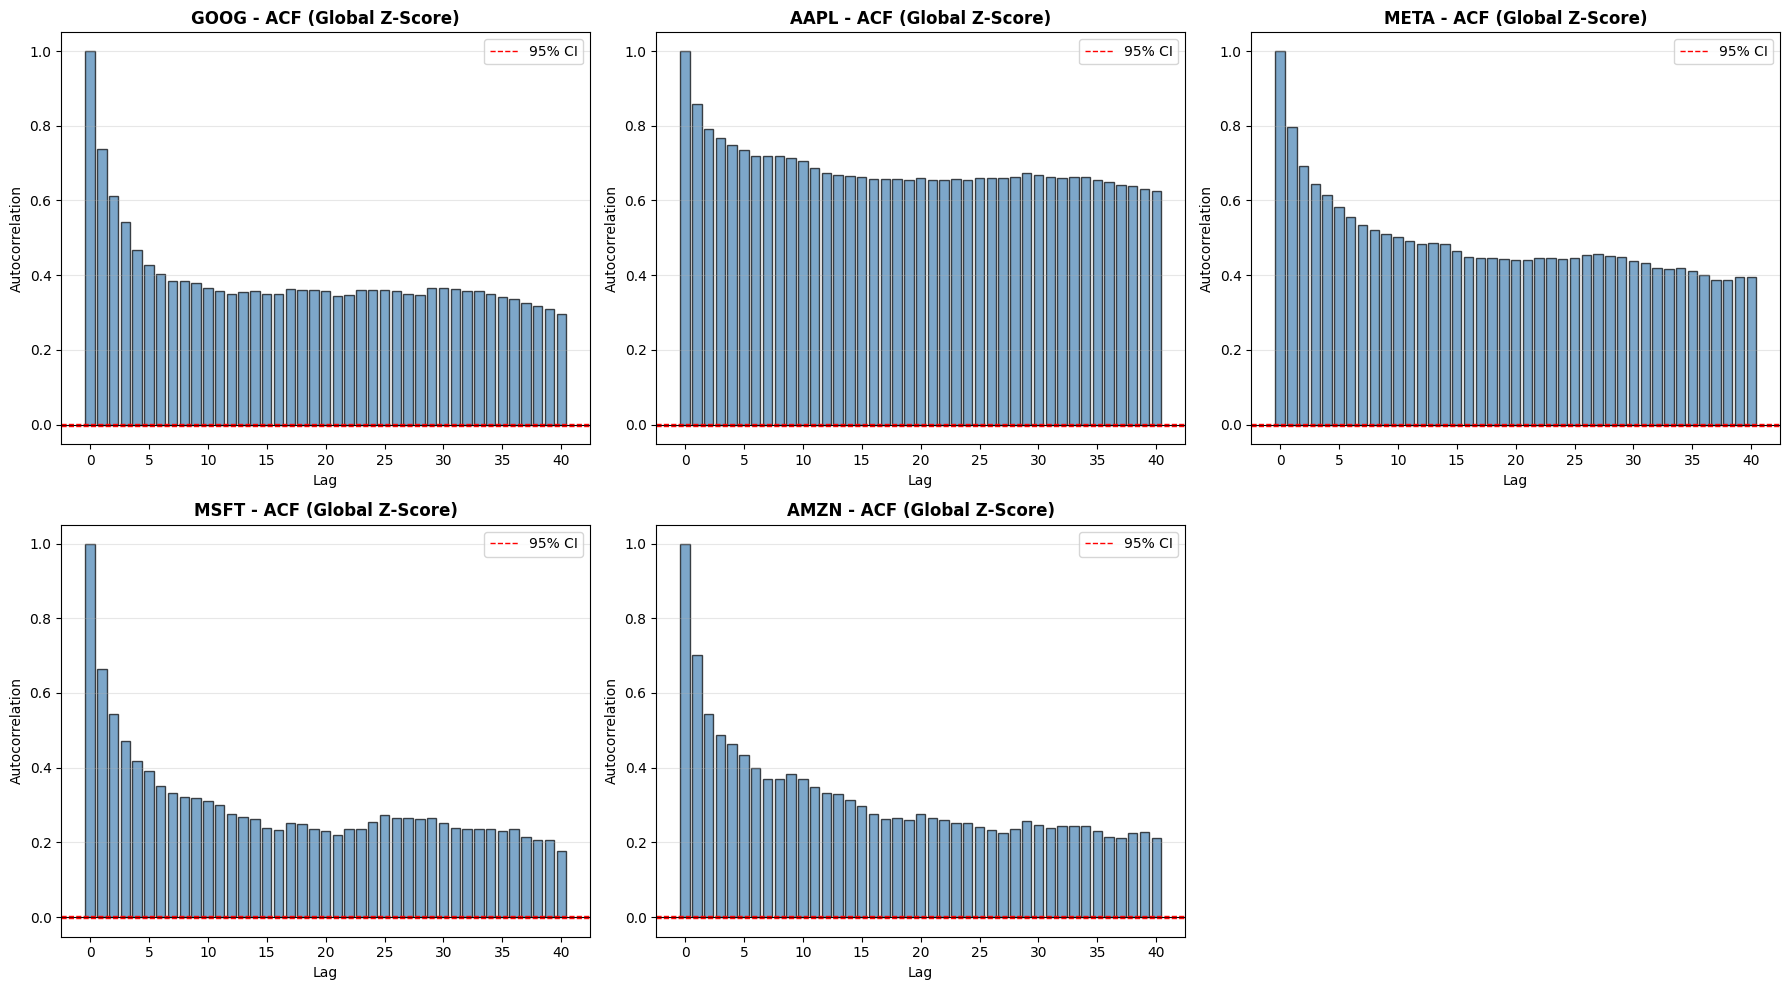

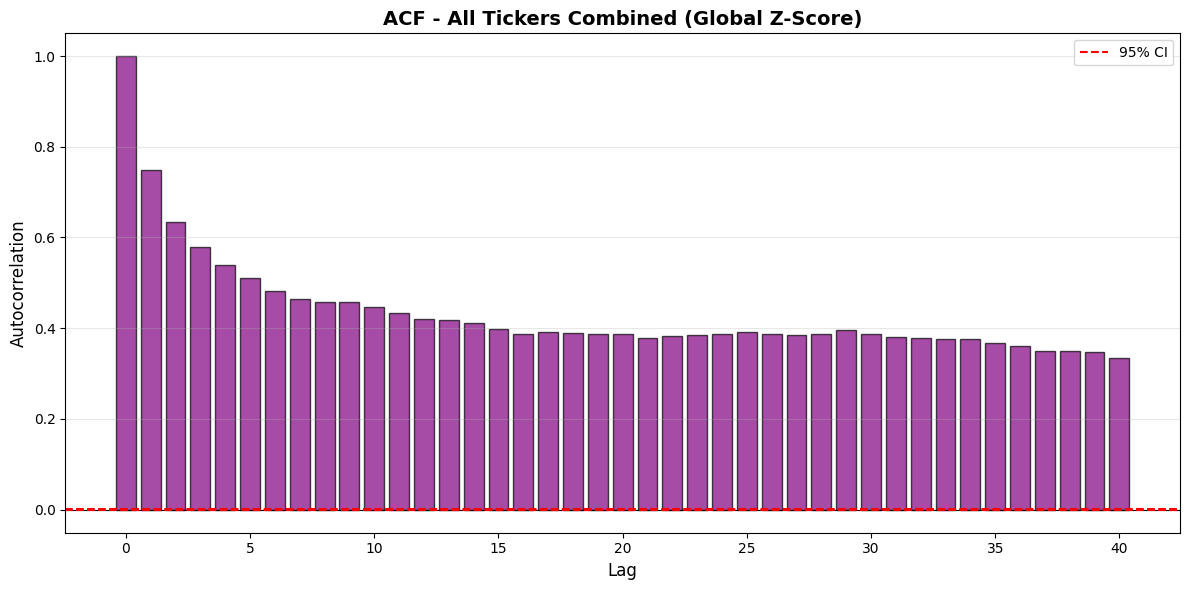

Combined dataset statistics:
  Total windows: 13820
  Total values: 3537920
  Mean: 0.0009
  Std: 0.9347


In [40]:
# Visualization of distributions and ACF for all datasets
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualize z-score distributions for each ticker
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    # Get globally z-score normalized windows
    windows_zscore = ticker_windows_global_zscore[ticker]
    
    # Flatten all windows to get all z-score values
    all_values = windows_zscore.flatten()
    
    # Plot distribution
    axes[idx].hist(all_values, bins=100, color='green', edgecolor='black', alpha=0.7, density=True)
    axes[idx].set_title(f'{ticker} - Z-Score Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Z-Score', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    mean_val = all_values.mean()
    std_val = all_values.std()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_val:.2f}')
    axes[idx].axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
    axes[idx].axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=1.5)
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 2. Calculate and plot ACF for each ticker after global z-score normalization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    # Get globally z-score normalized windows
    windows_zscore = ticker_windows_global_zscore[ticker]
    
    # Flatten all windows to create a single time series
    all_values = windows_zscore.flatten()
    
    # Calculate ACF
    acf_values = acf(all_values, nlags=40, fft=True)
    
    # Plot ACF
    axes[idx].bar(range(len(acf_values)), acf_values, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=1.96/np.sqrt(len(all_values)), color='red', linestyle='--', linewidth=1, label='95% CI')
    axes[idx].axhline(y=-1.96/np.sqrt(len(all_values)), color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f'{ticker} - ACF (Global Z-Score)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lag', fontsize=10)
    axes[idx].set_ylabel('Autocorrelation', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 3. ACF for all tickers combined
all_values_combined = all_windows_combined.flatten()

# Calculate ACF on combined dataset
acf_values_combined = acf(all_values_combined, nlags=40, fft=True)

# Plot ACF for all tickers combined
plt.figure(figsize=(12, 6))
plt.bar(range(len(acf_values_combined)), acf_values_combined, width=0.8, color='purple', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.axhline(y=1.96/np.sqrt(len(all_values_combined)), color='red', linestyle='--', linewidth=1.5, label='95% CI')
plt.axhline(y=-1.96/np.sqrt(len(all_values_combined)), color='red', linestyle='--', linewidth=1.5)
plt.title('ACF - All Tickers Combined (Global Z-Score)', fontsize=14, fontweight='bold')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Combined dataset statistics:")
print(f"  Total windows: {all_windows_combined.shape[0]}")
print(f"  Total values: {len(all_values_combined)}")
print(f"  Mean: {all_values_combined.mean():.4f}")
print(f"  Std: {all_values_combined.std():.4f}")


=== WAVELET TRANSFORM PROCESSING (SWT) ===
Input data shape: (13820, 256, 1)
Input data dtype: float32
Window length: 256
Squeezing extra dimension from shape (13820, 256, 1)
New shape: (13820, 256)
First window shape: (256,)
First window length: 256
Wavelet type: haar
Decomposition levels: 8
  Processing window 0/13820...
  Processing window 1000/13820...
  Processing window 2000/13820...
  Processing window 3000/13820...
  Processing window 4000/13820...
  Processing window 5000/13820...
  Processing window 6000/13820...
  Processing window 7000/13820...
  Processing window 8000/13820...
  Processing window 4000/13820...
  Processing window 5000/13820...
  Processing window 6000/13820...
  Processing window 7000/13820...
  Processing window 8000/13820...
  Processing window 9000/13820...
  Processing window 10000/13820...
  Processing window 11000/13820...
  Processing window 12000/13820...
  Processing window 13000/13820...
  Processing window 9000/13820...
  Processing window 10000

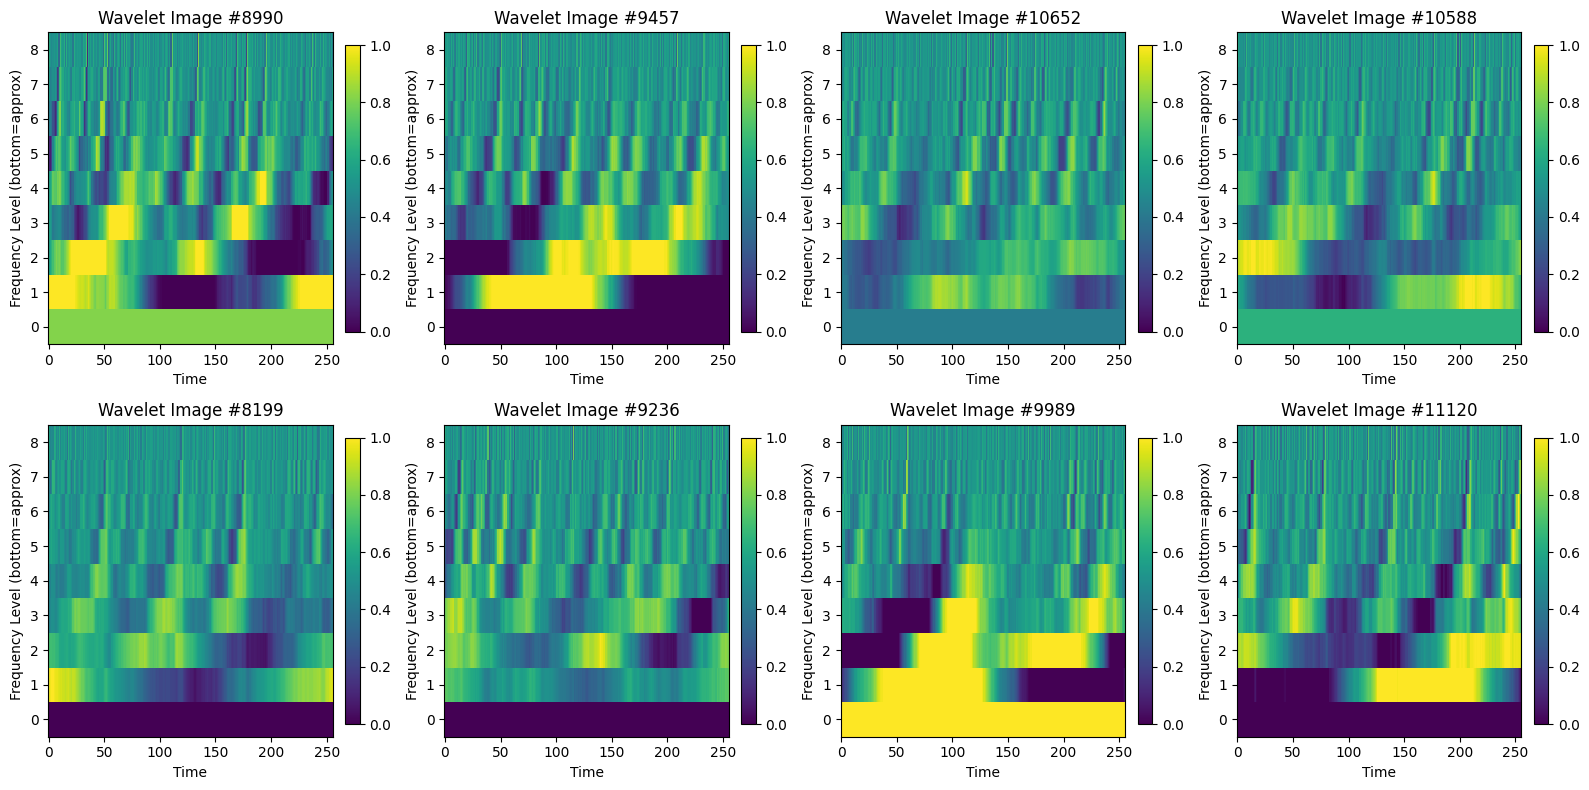


=== WAVELET IMAGE STATISTICS ===
Total wavelet images: 13820
Image dimensions: 9x256 (H x W)
Value range: [0.0000, 1.0000]
Mean: 0.5205
Std: 0.2272

✓ Wavelet images ready for diffusion model training!
  - Using Stationary Wavelet Transform (SWT) with complete coefficient preservation
  - Each image contains approximation AND detail coefficients
  - This preserves all frequency information for accurate reconstruction
  - Normalization parameters saved for inverse transformation
  - Images are in [0, 1] range suitable for diffusion models


In [41]:
# Convert z-score normalized time series windows to wavelet images using Haar wavelets (SWT)
# This creates single-channel wavelet coefficient images suitable for diffusion model training
# Uses Stationary Wavelet Transform (SWT) which maintains same length across all levels

import pywt
import numpy as np
import matplotlib.pyplot as plt

print("=== WAVELET TRANSFORM PROCESSING (SWT) ===")
print(f"Input data shape: {all_windows_combined.shape}")
print(f"Input data dtype: {all_windows_combined.dtype}")
print(f"Window length: {WINDOW_LENGTH}")

# Fix shape if there's an extra dimension
if all_windows_combined.ndim == 3 and all_windows_combined.shape[-1] == 1:
    print(f"Squeezing extra dimension from shape {all_windows_combined.shape}")
    all_windows_combined = all_windows_combined.squeeze(-1)
    print(f"New shape: {all_windows_combined.shape}")

# Verify data is correct shape
print(f"First window shape: {all_windows_combined[0].shape}")
print(f"First window length: {len(all_windows_combined[0])}")

# Configuration
wavelet_type = 'haar'
wavelet_level = int(np.log2(WINDOW_LENGTH))  # Maximum decomposition level for Haar

print(f"Wavelet type: {wavelet_type}")
print(f"Decomposition levels: {wavelet_level}")

# Step 1: Apply Stationary Wavelet Transform to each window
wavelet_coeffs_list = []

for i in range(len(all_windows_combined)):
    if i % 1000 == 0:
        print(f"  Processing window {i}/{len(all_windows_combined)}...")
    
    # Get the time series window (already z-score normalized)
    ts = all_windows_combined[i]
    
    # Ensure it's 1D and correct type
    ts = np.ascontiguousarray(ts.flatten(), dtype=np.float64)
    
    # Final verification before SWT
    if len(ts) != WINDOW_LENGTH:
        print(f"ERROR: Window {i} has length {len(ts)}, expected {WINDOW_LENGTH}")
        continue
    
    # Apply Stationary Wavelet Transform (SWT) - KEEP ALL COEFFICIENTS
    # trim_approx=False preserves both approximation and detail coefficients
    coeffs = pywt.swt(ts, wavelet_type, level=wavelet_level, trim_approx=False)
    
    # coeffs is a list of (cA, cD) tuples: [(cA_n, cD_n), (cA_n-1, cD_n-1), ..., (cA_1, cD_1)]
    # We need to stack ALL coefficients to preserve complete information
    # Stack as: [cA_n, cD_n, cD_n-1, ..., cD_1]
    coeff_arrays = [coeffs[0][0]]  # Start with approximation coefficients at coarsest level
    for cA, cD in coeffs:
        coeff_arrays.append(cD)  # Add all detail coefficients
    
    # Stack all coefficients to form a 2D image
    # Shape: (wavelet_level + 1, WINDOW_LENGTH) - one row for cA, rest for cD at each level
    wavelet_image = np.array(coeff_arrays, dtype=np.float32)
    
    wavelet_coeffs_list.append(wavelet_image)

# Stack all wavelet images
wavelet_coeffs_array = np.array(wavelet_coeffs_list, dtype=np.float32)  # Shape: (N, wavelet_level+1, WINDOW_LENGTH)

print(f"\nWavelet coefficients shape: {wavelet_coeffs_array.shape}")
print(f"  Including approximation coefficients (first row) and {wavelet_level} detail coefficient levels")
print(f"Coefficient range: [{wavelet_coeffs_array.min():.4f}, {wavelet_coeffs_array.max():.4f}]")
print(f"Coefficient mean: {wavelet_coeffs_array.mean():.4f}")
print(f"Coefficient std: {wavelet_coeffs_array.std():.4f}")

# Verify non-zero coefficients
non_zero_count = np.count_nonzero(wavelet_coeffs_array)
print(f"Non-zero coefficients: {non_zero_count} / {wavelet_coeffs_array.size} ({100*non_zero_count/wavelet_coeffs_array.size:.2f}%)")

# Step 2: Normalize wavelet coefficients to [0, 1] for diffusion model
# Use percentile-based normalization to handle outliers
p5 = np.percentile(wavelet_coeffs_array, 5)
p95 = np.percentile(wavelet_coeffs_array, 95)

print(f"\nPercentile normalization:")
print(f"  5th percentile: {p5:.4f}")
print(f"  95th percentile: {p95:.4f}")

# Clip and normalize
eps = 1e-8
wavelet_coeffs_clipped = np.clip(wavelet_coeffs_array, p5, p95)
wavelet_coeffs_normalized = (wavelet_coeffs_clipped - p5) / (p95 - p5 + eps)

print(f"Normalized range: [{wavelet_coeffs_normalized.min():.4f}, {wavelet_coeffs_normalized.max():.4f}]")
print(f"Normalized mean: {wavelet_coeffs_normalized.mean():.4f}")
print(f"Normalized std: {wavelet_coeffs_normalized.std():.4f}")

# Step 3: Reshape to (N, H, W, 1) format for diffusion model
# H = wavelet_level + 1 (1 approx + wavelet_level details), W = WINDOW_LENGTH (time)
wavelet_images = wavelet_coeffs_normalized[..., np.newaxis]  # Add channel dimension

print(f"\nFinal wavelet images shape: {wavelet_images.shape}")
print(f"  N (samples): {wavelet_images.shape[0]}")
print(f"  H (frequency levels): {wavelet_images.shape[1]} (1 approximation + {wavelet_level} detail levels)")
print(f"  W (time points): {wavelet_images.shape[2]}")
print(f"  C (channels): {wavelet_images.shape[3]}")

# Step 4: Save wavelet images and normalization parameters
np.save('wavelet_images.npy', wavelet_images)
print(f"\nSaved wavelet images to 'wavelet_images.npy'")

# Save normalization parameters and metadata for inverse transform
wavelet_norm_params = {
    'p5': float(p5),
    'p95': float(p95),
    'wavelet_type': wavelet_type,
    'wavelet_level': wavelet_level,
    'window_length': WINDOW_LENGTH,
    'transform_type': 'swt',  # Important: indicates we used SWT
    'trim_approx': False  # Important: we kept approximation coefficients
}
np.save('wavelet_normalization_params.npy', wavelet_norm_params)
print(f"Saved normalization parameters to 'wavelet_normalization_params.npy'")

# Step 5: Visualize sample wavelet images
num_samples_to_plot = min(8, len(wavelet_images))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Randomly select indices from all available images
random_indices = np.random.choice(len(wavelet_images), size=num_samples_to_plot, replace=False)

for idx, rand_idx in enumerate(random_indices):
    img = wavelet_images[rand_idx, :, :, 0]  # Remove channel dimension for visualization
    ax = axes[idx]
    
    im = ax.imshow(img, aspect='auto', origin='lower', cmap='viridis', 
                   interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f'Wavelet Image #{rand_idx+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency Level (bottom=approx)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Step 6: Display statistics
print(f"\n=== WAVELET IMAGE STATISTICS ===")
print(f"Total wavelet images: {len(wavelet_images)}")
print(f"Image dimensions: {wavelet_images.shape[1]}x{wavelet_images.shape[2]} (H x W)")
print(f"Value range: [{wavelet_images.min():.4f}, {wavelet_images.max():.4f}]")
print(f"Mean: {wavelet_images.mean():.4f}")
print(f"Std: {wavelet_images.std():.4f}")

print(f"\n✓ Wavelet images ready for diffusion model training!")
print(f"  - Using Stationary Wavelet Transform (SWT) with complete coefficient preservation")
print(f"  - Each image contains approximation AND detail coefficients")
print(f"  - This preserves all frequency information for accurate reconstruction")
print(f"  - Normalization parameters saved for inverse transformation")
print(f"  - Images are in [0, 1] range suitable for diffusion models")


In [42]:
# Train diffusion model on single-channel wavelet images (robust, resumable)
# - Saves `wavelet_images.npy` if not already saved
# - Builds a Dataset from `wavelet_images`
# - Allocates UNet and Diffusion, supports resume from checkpoint
# - Checkpoints model and saves sample grids periodically





# --- Config (edit as needed) ---
OUT_DIR = './diffusion_checkpoints'
N_SAMPLES_FOR_VIS = 8
BATCH_SIZE = 32  # Increased batch size for better gradient estimates
EPOCHS = 40 # Increased for better convergence
LR = 1e-3 # Increased learning rate
TIMESTEPS = 1500
SAVE_EVERY_STEPS = 10000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESUME_FROM = None  # set to path of checkpoint to resume

os.makedirs(OUT_DIR, exist_ok=True)

# --- Obtain wavelet_images (either from notebook or saved file) ---
try:
    imgs = wavelet_images  # noqa: F821
except NameError:
    if os.path.exists('wavelet_images.npy'):
        imgs = np.load('wavelet_images.npy')
    else:
        raise RuntimeError("`wavelet_images` not found in notebook and './wavelet_images.npy' does not exist. Run the wavelet image cell first.")

# Ensure values in [0,1]
if imgs.dtype != np.float32:
    imgs = imgs.astype('float32')

# Save to disk for reproducibility
np.save('wavelet_images.npy', imgs)
print('Saved wavelet_images.npy (shape:', imgs.shape, ')')

# Expect shape (N, H, W, 1)
if imgs.ndim != 4 or imgs.shape[-1] != 1:
    raise RuntimeError(f"Unexpected wavelet_images shape: {imgs.shape}. Expected (N, H, W, 1)")

H, W = imgs.shape[1], imgs.shape[2]

class WaveletDataset(Dataset):
    def __init__(self, arr):
        self.arr = arr
    def __len__(self):
        return len(self.arr)
    def __getitem__(self, i):
        img = self.arr[i]
        # transpose to (C, H, W) and scale [0,1] -> [-1,1]
        img = np.transpose(img, (2, 0, 1)).copy()
        img = img * 2.0 - 1.0
        return torch.from_numpy(img)

# --- Create dataset and dataloader ---
dataset = WaveletDataset(imgs)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Model and diffusion allocation ---
model = UNet(in_channels=1).to(DEVICE)
diffusion = Diffusion(model, timesteps=TIMESTEPS, device=DEVICE, beta_schedule='cosine')
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)

start_step = 0
start_epoch = 0
if RESUME_FROM is not None and os.path.exists(RESUME_FROM):
    ckpt = torch.load(RESUME_FROM, map_location=DEVICE)
    if 'model' in ckpt:
        model.load_state_dict(ckpt['model'])
    elif 'state_dict' in ckpt:
        model.load_state_dict(ckpt['state_dict'])
    if 'opt' in ckpt:
        opt.load_state_dict(ckpt['opt'])
    start_epoch = ckpt.get('epoch', 0)
    start_step = ckpt.get('step', 0)
    print('Resumed from', RESUME_FROM, 'epoch', start_epoch, 'step', start_step)

# --- Helper: sample and save grid ---
@torch.no_grad()
def sample_and_save(step, num_samples=N_SAMPLES_FOR_VIS):
    model.eval()
    try:
        samples = diffusion.sample((num_samples, 1, H, W))
    except Exception as e:
        # fallback: sample smaller batch if OOM
        print('Sampling failed:', e)
        torch.cuda.empty_cache()
        samples = diffusion.sample((min(num_samples, 4), 1, H, W))
    samples = samples.clamp(-1, 1)
    samples = (samples + 1.0) / 2.0  # to [0,1]
    grid = vutils.make_grid(samples.cpu(), nrow=min(8, num_samples))
    out_path = os.path.join(OUT_DIR, f'samples_step_{step}.png')
    vutils.save_image(grid, out_path)
    print('Saved samples to', out_path)
    model.train()

# --- Training loop ---
model.train()
global_step = start_step
for epoch in range(start_epoch, EPOCHS):
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch in pbar:
        imgs_batch = batch.to(DEVICE)
        bs = imgs_batch.shape[0]
        
        # Sample timesteps uniformly
        t = torch.randint(0, diffusion.timesteps, (bs,), device=DEVICE).long()
        
        loss = diffusion.p_losses(imgs_batch, t, loss_type='huber')

        opt.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        opt.step()

        global_step += 1
        pbar.set_postfix({'loss': float(loss.detach().cpu().item()), 'step': global_step})

        if global_step % SAVE_EVERY_STEPS == 0:
            ckpt = {'model': model.state_dict(), 'opt': opt.state_dict(), 'epoch': epoch, 'step': global_step}
            ckpt_path = os.path.join(OUT_DIR, f'ckpt_step_{global_step}.pt')
            torch.save(ckpt, ckpt_path)
            print(f'Saved checkpoint to {ckpt_path}')
            sample_and_save(global_step)

    # end of epoch - save epoch checkpoint
    ckpt = {'model': model.state_dict(), 'opt': opt.state_dict(), 'epoch': epoch + 1, 'step': global_step}
    torch.save(ckpt, os.path.join(OUT_DIR, f'ckpt_epoch_{epoch+1}.pt'))
    print(f'Saved epoch {epoch+1} checkpoint')

print('Training finished. Checkpoints and samples are in', OUT_DIR)

Saved wavelet_images.npy (shape: (13820, 9, 256, 1) )


Epoch 1/40: 100%|██████████| 432/432 [00:17<00:00, 24.26it/s, loss=0.0232, step=432]



Saved epoch 1 checkpoint


Epoch 2/40: 100%|██████████| 432/432 [00:17<00:00, 24.07it/s, loss=0.0291, step=864]



Saved epoch 2 checkpoint


Epoch 3/40: 100%|██████████| 432/432 [00:18<00:00, 24.00it/s, loss=0.0201, step=1296] 



Saved epoch 3 checkpoint


Epoch 4/40: 100%|██████████| 432/432 [00:18<00:00, 23.92it/s, loss=0.0106, step=1728] 



Saved epoch 4 checkpoint


Epoch 5/40: 100%|██████████| 432/432 [00:18<00:00, 23.83it/s, loss=0.0175, step=2160] 



Saved epoch 5 checkpoint


Epoch 6/40: 100%|██████████| 432/432 [00:18<00:00, 23.81it/s, loss=0.0139, step=2592]



Saved epoch 6 checkpoint


Epoch 7/40: 100%|██████████| 432/432 [00:18<00:00, 23.79it/s, loss=0.0187, step=3024] 



Saved epoch 7 checkpoint


Epoch 8/40: 100%|██████████| 432/432 [00:18<00:00, 23.75it/s, loss=0.0172, step=3456]



Saved epoch 8 checkpoint


Epoch 9/40: 100%|██████████| 432/432 [00:18<00:00, 23.73it/s, loss=0.0198, step=3888] 



Saved epoch 9 checkpoint


Epoch 10/40: 100%|██████████| 432/432 [00:18<00:00, 23.73it/s, loss=0.016, step=4320]  



Saved epoch 10 checkpoint


Epoch 11/40: 100%|██████████| 432/432 [00:18<00:00, 23.70it/s, loss=0.0116, step=4752]



Saved epoch 11 checkpoint


Epoch 12/40: 100%|██████████| 432/432 [00:18<00:00, 23.66it/s, loss=0.0127, step=5184] 



Saved epoch 12 checkpoint


Epoch 13/40: 100%|██████████| 432/432 [00:18<00:00, 23.66it/s, loss=0.0262, step=5616]



Saved epoch 13 checkpoint


Epoch 14/40: 100%|██████████| 432/432 [00:18<00:00, 23.65it/s, loss=0.0224, step=6048] 



Saved epoch 14 checkpoint


Epoch 15/40: 100%|██████████| 432/432 [00:18<00:00, 23.61it/s, loss=0.017, step=6480]  



Saved epoch 15 checkpoint


Epoch 16/40: 100%|██████████| 432/432 [00:18<00:00, 23.60it/s, loss=0.0173, step=6912] 



Saved epoch 16 checkpoint


Epoch 17/40: 100%|██████████| 432/432 [00:18<00:00, 23.61it/s, loss=0.0185, step=7344] 



Saved epoch 17 checkpoint


Epoch 18/40: 100%|██████████| 432/432 [00:18<00:00, 23.59it/s, loss=0.0153, step=7776] 



Saved epoch 18 checkpoint


Epoch 19/40: 100%|██████████| 432/432 [00:18<00:00, 23.57it/s, loss=0.0168, step=8208] 



Saved epoch 19 checkpoint


Epoch 20/40: 100%|██████████| 432/432 [00:18<00:00, 23.57it/s, loss=0.0187, step=8640] 



Saved epoch 20 checkpoint


Epoch 21/40: 100%|██████████| 432/432 [00:18<00:00, 23.54it/s, loss=0.0153, step=9072] 



Saved epoch 21 checkpoint


Epoch 22/40: 100%|██████████| 432/432 [00:18<00:00, 23.52it/s, loss=0.0147, step=9504] 



Saved epoch 22 checkpoint


Epoch 23/40: 100%|██████████| 432/432 [00:18<00:00, 23.54it/s, loss=0.021, step=9936]  



Saved epoch 23 checkpoint


Epoch 24/40:  15%|█▍        | 63/432 [00:02<00:15, 23.56it/s, loss=0.0152, step=1e+4] 

Saved checkpoint to ./diffusion_checkpoints/ckpt_step_10000.pt


Epoch 24/40:  15%|█▌        | 66/432 [00:08<03:35,  1.70it/s, loss=0.0174, step=1e+4]

Saved samples to ./diffusion_checkpoints/samples_step_10000.png


Epoch 24/40: 100%|██████████| 432/432 [00:23<00:00, 18.11it/s, loss=0.0162, step=10368] 



Saved epoch 24 checkpoint


Epoch 25/40: 100%|██████████| 432/432 [00:18<00:00, 23.47it/s, loss=0.015, step=10800]  



Saved epoch 25 checkpoint


Epoch 26/40: 100%|██████████| 432/432 [00:18<00:00, 23.48it/s, loss=0.0194, step=11232] 



Saved epoch 26 checkpoint


Epoch 27/40: 100%|██████████| 432/432 [00:18<00:00, 23.45it/s, loss=0.0116, step=11664] 



Saved epoch 27 checkpoint


Epoch 28/40: 100%|██████████| 432/432 [00:18<00:00, 23.47it/s, loss=0.0153, step=12096] 



Saved epoch 28 checkpoint


Epoch 29/40: 100%|██████████| 432/432 [00:18<00:00, 23.48it/s, loss=0.0138, step=12528] 



Saved epoch 29 checkpoint


Epoch 30/40: 100%|██████████| 432/432 [00:18<00:00, 23.46it/s, loss=0.0166, step=12960] 



Saved epoch 30 checkpoint


Epoch 31/40: 100%|██████████| 432/432 [00:18<00:00, 23.41it/s, loss=0.0119, step=13392] 



Saved epoch 31 checkpoint


Epoch 32/40: 100%|██████████| 432/432 [00:18<00:00, 23.45it/s, loss=0.014, step=13824]  



Saved epoch 32 checkpoint


Epoch 33/40: 100%|██████████| 432/432 [00:18<00:00, 23.44it/s, loss=0.0222, step=14256] 



Saved epoch 33 checkpoint


Epoch 34/40: 100%|██████████| 432/432 [00:18<00:00, 23.41it/s, loss=0.0136, step=14688] 



Saved epoch 34 checkpoint


Epoch 35/40: 100%|██████████| 432/432 [00:18<00:00, 23.42it/s, loss=0.0105, step=15120] 



Saved epoch 35 checkpoint


Epoch 36/40: 100%|██████████| 432/432 [00:18<00:00, 23.43it/s, loss=0.0137, step=15552] 



Saved epoch 36 checkpoint


Epoch 37/40: 100%|██████████| 432/432 [00:18<00:00, 23.39it/s, loss=0.0135, step=15984] 



Saved epoch 37 checkpoint


Epoch 38/40: 100%|██████████| 432/432 [00:18<00:00, 23.41it/s, loss=0.0106, step=16416] 



Saved epoch 38 checkpoint


Epoch 39/40: 100%|██████████| 432/432 [00:18<00:00, 23.44it/s, loss=0.0153, step=16848] 



Saved epoch 39 checkpoint


Epoch 40/40: 100%|██████████| 432/432 [00:18<00:00, 23.41it/s, loss=0.0109, step=17280] 



Saved epoch 40 checkpoint
Training finished. Checkpoints and samples are in ./diffusion_checkpoints


Loading checkpoint: ./diffusion_checkpoints/ckpt_epoch_40.pt
Using image dimensions: 9x256
Generating 1000 synthetic single-channel wavelet images with temperature=1.5...
Saved 1000 synthetic samples to 'synthetic_wavelet_images.npy'
Saved 1000 synthetic samples to 'synthetic_wavelet_images.npy'


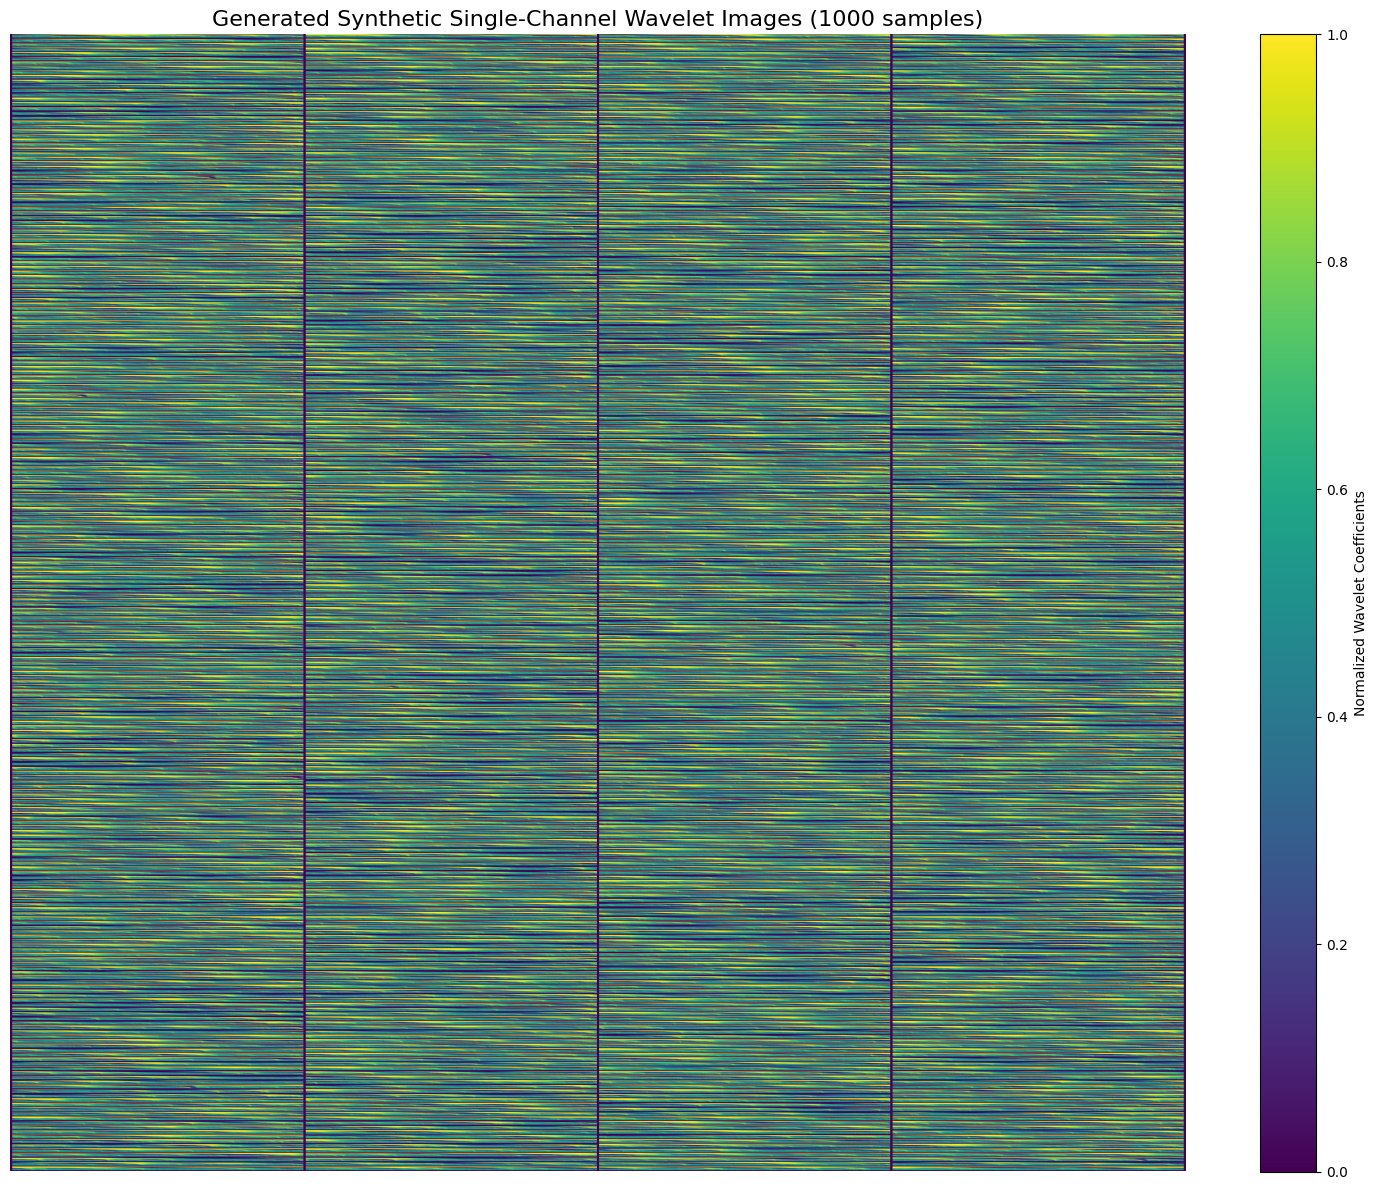

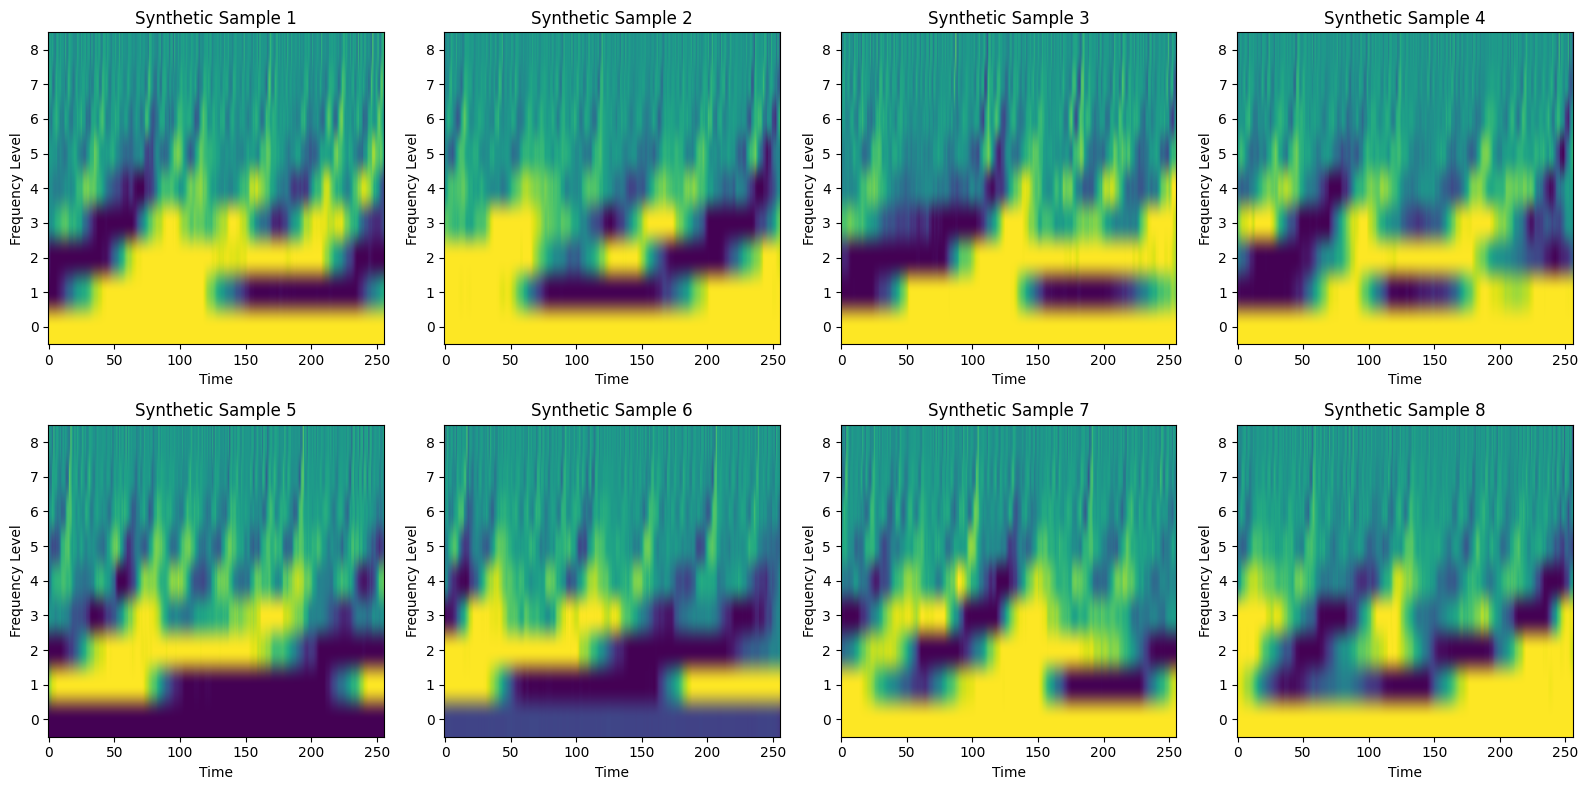

Generated 1000 synthetic single-channel wavelet images successfully!
- Single channel represents volume data


In [43]:
# Generate synthetic single-channel wavelet images using trained diffusion model
# Load the latest checkpoint and generate new samples

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils
from src.diffusion.unet import UNet
from src.diffusion.diffusion import Diffusion
import os
import glob

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = './diffusion_checkpoints'
NUM_SAMPLES = 1000  # Number of synthetic images to generate
SAVE_SAMPLES = True  # Whether to save generated samples to disk
TEMPERATURE = 1.5  # Temperature for sampling (>1 = more diversity)

# Find the latest checkpoint
checkpoint_files = glob.glob(os.path.join(CHECKPOINT_DIR, 'ckpt_epoch_*.pt'))
if not checkpoint_files:
    raise RuntimeError(f"No checkpoint files found in {CHECKPOINT_DIR}. Train the model first.")

latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
print(f"Loading checkpoint: {latest_checkpoint}")

# Load model architecture and weights
model = UNet(in_channels=1).to(DEVICE)
diffusion = Diffusion(model, timesteps=1000, device=DEVICE)

checkpoint = torch.load(latest_checkpoint, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

# Get image dimensions from saved wavelet_images
if os.path.exists('wavelet_images.npy'):
    saved_imgs = np.load('wavelet_images.npy')
    H, W = saved_imgs.shape[1], saved_imgs.shape[2]
    print(f"Using image dimensions: {H}x{W}")
else:
    raise RuntimeError("wavelet_images.npy not found. Run the wavelet image generation cell first.")

print(f"Generating {NUM_SAMPLES} synthetic single-channel wavelet images with temperature={TEMPERATURE}...")

synthetic_samples = diffusion.sample((NUM_SAMPLES, 1, H, W), temperature=TEMPERATURE)

# Convert from [-1,1] to [0,1] for visualization
synthetic_samples = synthetic_samples.clamp(-1, 1)
synthetic_samples = (synthetic_samples + 1.0) / 2.0

# Save samples if requested
if SAVE_SAMPLES:
    synthetic_samples_np = synthetic_samples.cpu().numpy()
    # Transpose from (N, C, H, W) to (N, H, W, C)
    synthetic_samples_np = np.transpose(synthetic_samples_np, (0, 2, 3, 1))
    np.save('synthetic_wavelet_images.npy', synthetic_samples_np)
    print(f"Saved {NUM_SAMPLES} synthetic samples to 'synthetic_wavelet_images.npy'")

# Create visualization grid
grid = vutils.make_grid(synthetic_samples.cpu(), nrow=4, padding=2, normalize=False)
grid_np = grid.permute(1, 2, 0).numpy()

# Display the generated samples
plt.figure(figsize=(15, 12))
plt.imshow(grid_np[:, :, 0], cmap='viridis', aspect='auto')
plt.colorbar(label='Normalized Wavelet Coefficients')
plt.title(f'Generated Synthetic Single-Channel Wavelet Images ({NUM_SAMPLES} samples)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Display individual samples for detailed inspection
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, NUM_SAMPLES)):
    sample = synthetic_samples[i, 0].cpu().numpy()
    axes[i].imshow(sample, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f'Synthetic Sample {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Frequency Level')

# Hide unused subplots
for i in range(min(8, NUM_SAMPLES), 8):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Generated {NUM_SAMPLES} synthetic single-channel wavelet images successfully!")
print("- Single channel represents volume data")

In [44]:
# Prepare data for analysis: reconstruct synthetic time series to z-score normalized log volume space
# This cell produces comparable datasets at the same preprocessing stage (log + z-score normalization)

import pywt
import numpy as np

print("=== PREPARING DATA FOR ANALYSIS ===")

# ============================================================================
# PART 1: RECONSTRUCT SYNTHETIC TIME SERIES FROM WAVELET IMAGES
# ============================================================================

# Load synthetic wavelet images (either from current generation or saved file)
try:
    synthetic_imgs = synthetic_samples.cpu().numpy()
    # Transpose from (N, C, H, W) to (N, H, W, C)
    synthetic_imgs = np.transpose(synthetic_imgs, (0, 2, 3, 1))
except NameError:
    if os.path.exists('synthetic_wavelet_images.npy'):
        synthetic_imgs = np.load('synthetic_wavelet_images.npy')
        print("Loaded synthetic wavelet images from file")
    else:
        raise RuntimeError("No synthetic images available. Generate samples first.")

print(f"Synthetic wavelet images shape: {synthetic_imgs.shape}")

# Load wavelet normalization parameters
if os.path.exists('wavelet_normalization_params.npy'):
    wavelet_norm_params = np.load('wavelet_normalization_params.npy', allow_pickle=True).item()
    p5 = wavelet_norm_params['p5']
    p95 = wavelet_norm_params['p95']
    wavelet_type = wavelet_norm_params['wavelet_type']
    wavelet_level = wavelet_norm_params['wavelet_level']
    print(f"Loaded wavelet normalization params: p5={p5:.4f}, p95={p95:.4f}")
else:
    raise RuntimeError("wavelet_normalization_params.npy not found. Run wavelet preprocessing first.")

# Step 1: Denormalize wavelet coefficients from [0,1] to original coefficient range
eps = 1e-8
synthetic_imgs_squeezed = synthetic_imgs.squeeze(-1)  # Remove channel dim: (N, H, W)
wavelet_coeffs_denorm = synthetic_imgs_squeezed * (p95 - p5 + eps) + p5

print(f"\nDenormalized wavelet coefficients:")
print(f"  Shape: {wavelet_coeffs_denorm.shape}")
print(f"  Range: [{wavelet_coeffs_denorm.min():.4f}, {wavelet_coeffs_denorm.max():.4f}]")

# Step 2: Apply Inverse Stationary Wavelet Transform to get z-score normalized log volumes
reconstructed_series_list = []

for i in range(len(wavelet_coeffs_denorm)):
    if i % 100 == 0:
        print(f"  Reconstructing series {i}/{len(wavelet_coeffs_denorm)}...")
    
    # Get coefficients for this series
    coeffs_denorm = wavelet_coeffs_denorm[i]  # Shape: (wavelet_level+1, WINDOW_LENGTH)
    
    # Reconstruct the coefficient list in the format expected by iswt
    # First row is cA (approximation), remaining rows are details
    # iswt expects: [(cA_n, cD_n), (cA_n-1, cD_n-1), ..., (cA_1, cD_1)]
    
    # Extract approximation and detail coefficients
    cA = coeffs_denorm[0]  # Approximation coefficients (first row)
    detail_coeffs = coeffs_denorm[1:]  # All detail coefficient levels
    
    # Build coefficient list for iswt
    # For SWT, all levels have the same approximation, paired with different details
    coeffs_list = []
    for level_idx in range(wavelet_level):
        cD = detail_coeffs[level_idx]
        coeffs_list.append((cA.copy(), cD.copy()))
    
    # Apply inverse SWT to reconstruct the time series
    reconstruction = pywt.iswt(coeffs_list, wavelet_type)
    
    # Ensure correct length (iswt might return slightly different length)
    if len(reconstruction) > WINDOW_LENGTH:
        reconstruction = reconstruction[:WINDOW_LENGTH]
    elif len(reconstruction) < WINDOW_LENGTH:
        reconstruction = np.pad(reconstruction, (0, WINDOW_LENGTH - len(reconstruction)), mode='edge')
    
    reconstructed_series_list.append(reconstruction)

# Stack all reconstructed synthetic series (these are in z-score normalized log volume space)
synthetic_zscore_log_volumes = np.stack(reconstructed_series_list)

print(f"\nSynthetic z-score normalized log volumes:")
print(f"  Shape: {synthetic_zscore_log_volumes.shape}")
print(f"  Mean: {synthetic_zscore_log_volumes.mean():.6f}")
print(f"  Std: {synthetic_zscore_log_volumes.std():.6f}")
print(f"  Min: {synthetic_zscore_log_volumes.min():.4f}")
print(f"  Max: {synthetic_zscore_log_volumes.max():.4f}")

# ============================================================================
# PART 2: PREPARE ORIGINAL TIME SERIES AT SAME PREPROCESSING STAGE
# ============================================================================

# The original data is already in z-score normalized log volume space
# This is the all_windows_combined variable from cell 2
original_zscore_log_volumes = all_windows_combined.copy()

print(f"\nOriginal z-score normalized log volumes:")
print(f"  Shape: {original_zscore_log_volumes.shape}")
print(f"  Mean: {original_zscore_log_volumes.mean():.6f}")
print(f"  Std: {original_zscore_log_volumes.std():.6f}")
print(f"  Min: {original_zscore_log_volumes.min():.4f}")
print(f"  Max: {original_zscore_log_volumes.max():.4f}")

# ============================================================================
# SUMMARY: DATASETS READY FOR COMPARISON
# ============================================================================

print("\n" + "="*70)
print("DATASETS READY FOR ANALYSIS")
print("="*70)
print(f"Both datasets are now at the same preprocessing stage:")
print(f"  - Log-transformed volumes")
print(f"  - Z-score normalized (mean≈0, std≈1)")
print(f"  - Window length: {WINDOW_LENGTH}")
print(f"\nOriginal dataset:")
print(f"  Variable: original_zscore_log_volumes")
print(f"  Shape: {original_zscore_log_volumes.shape}")
print(f"\nSynthetic dataset:")
print(f"  Variable: synthetic_zscore_log_volumes")
print(f"  Shape: {synthetic_zscore_log_volumes.shape}")
print("="*70)


=== PREPARING DATA FOR ANALYSIS ===
Synthetic wavelet images shape: (1000, 9, 256, 1)
Loaded wavelet normalization params: p5=-4.1916, p95=3.7898

Denormalized wavelet coefficients:
  Shape: (1000, 9, 256)
  Range: [-4.1916, 3.7898]
  Reconstructing series 0/1000...
  Reconstructing series 100/1000...
  Reconstructing series 100/1000...
  Reconstructing series 200/1000...
  Reconstructing series 200/1000...
  Reconstructing series 300/1000...
  Reconstructing series 300/1000...
  Reconstructing series 400/1000...
  Reconstructing series 400/1000...
  Reconstructing series 500/1000...
  Reconstructing series 500/1000...
  Reconstructing series 600/1000...
  Reconstructing series 600/1000...
  Reconstructing series 700/1000...
  Reconstructing series 700/1000...
  Reconstructing series 800/1000...
  Reconstructing series 900/1000...
  Reconstructing series 800/1000...
  Reconstructing series 900/1000...

Synthetic z-score normalized log volumes:
  Shape: (1000, 256)
  Mean: 0.094192
  St

=== COMPARISON: ORIGINAL vs SYNTHETIC Z-SCORE NORMALIZED LOG VOLUMES ===
Original data: 3537920 values from 13820 windows
Synthetic data: 256000 values from 1000 windows


/tmp/ipykernel_9000/917437111.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_boxplot, labels=['Original', 'Synthetic'], patch_artist=True)


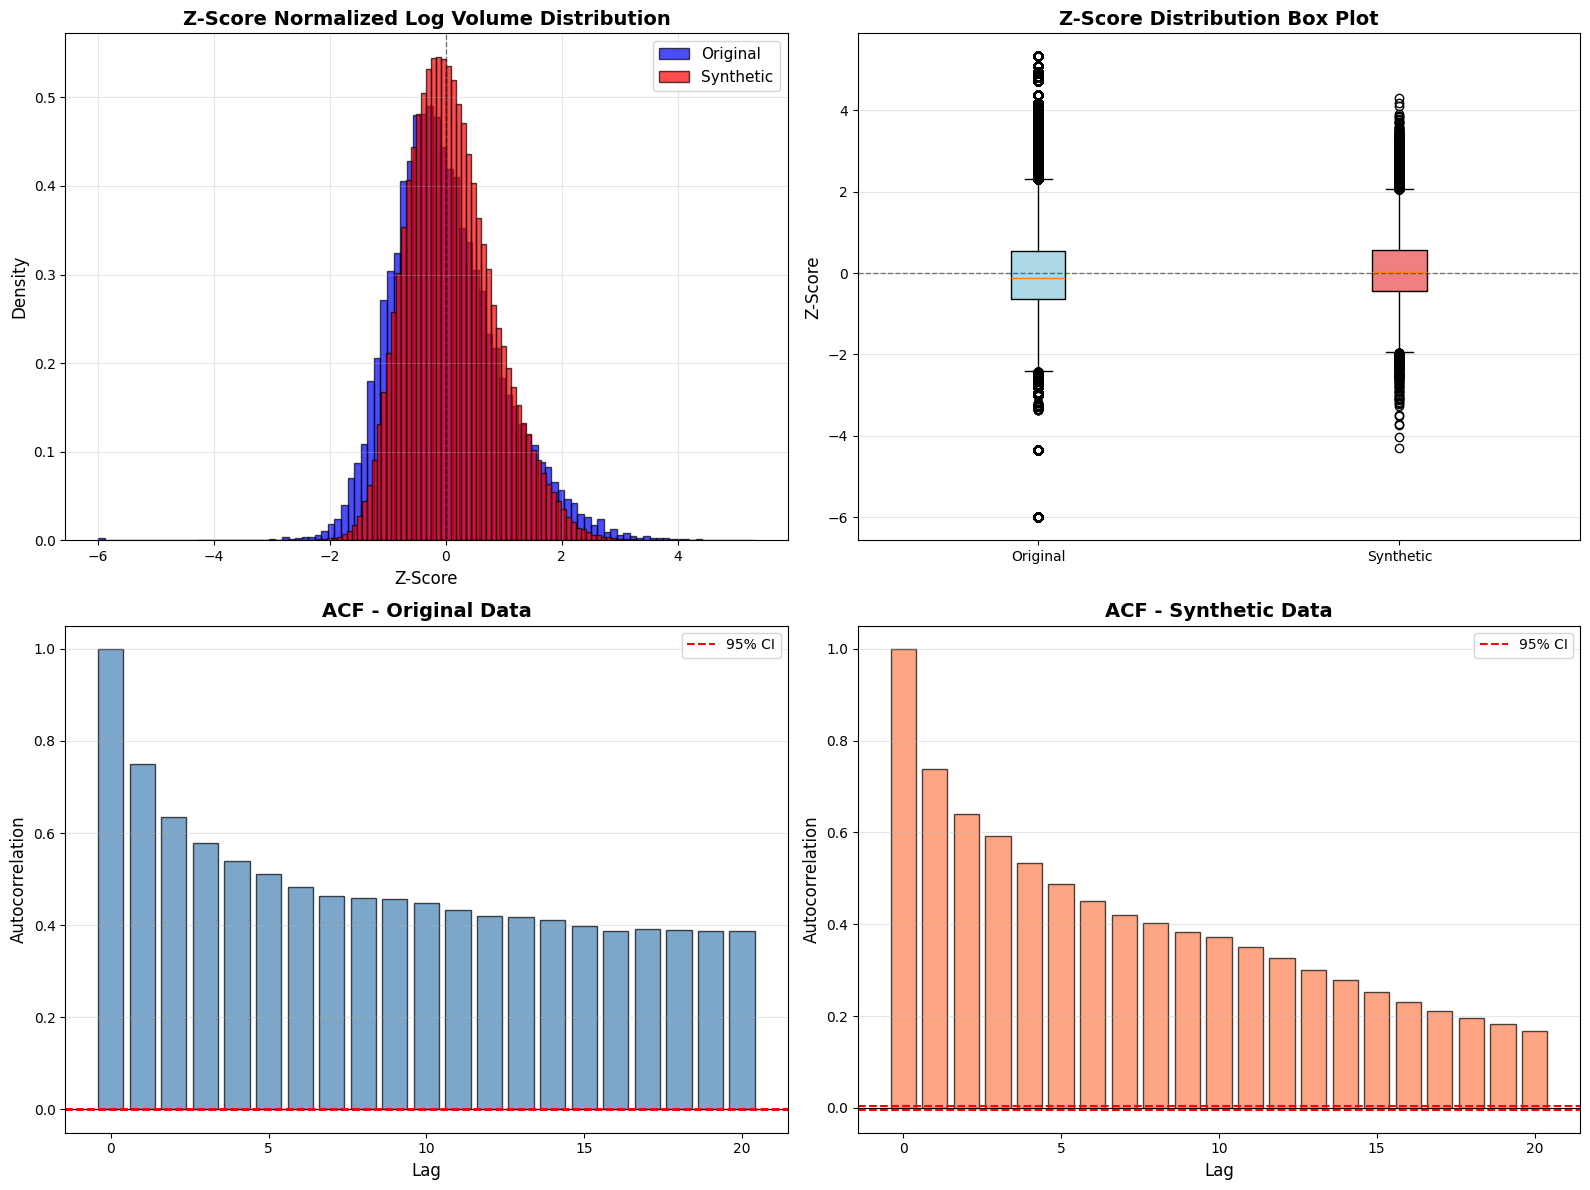


=== DISTRIBUTION STATISTICS ===
Original Z-Score:
  Mean: 0.000866
  Std: 0.934741
  Min: -6.0000
  Max: 5.3281

Synthetic Z-Score:
  Mean: 0.094192
  Std: 0.755242
  Min: -4.2908
  Max: 4.3041

=== STATISTICAL TEST ===
Kolmogorov-Smirnov Test:
  Statistic: 0.090717
  P-value: 0.000000
  Result: Distributions are statistically different

=== ACF COMPARISON (first 10 lags) ===
Lag  | Original  | Synthetic | Difference
-----|-----------|-----------|------------
   0 |  1.000000 |  1.000000 |   0.000000
   1 |  0.749221 |  0.737370 |   0.011851
   2 |  0.633946 |  0.640590 |   0.006644
   3 |  0.579063 |  0.593154 |   0.014091
   4 |  0.540100 |  0.533704 |   0.006395
   5 |  0.511039 |  0.487578 |   0.023461
   6 |  0.482038 |  0.450716 |   0.031322
   7 |  0.463384 |  0.419834 |   0.043551
   8 |  0.458559 |  0.402891 |   0.055668
   9 |  0.457231 |  0.384281 |   0.072950

✓ Analysis complete!


In [45]:
# Compare distributions and ACF of original vs synthetic z-score normalized log volumes
# This cell analyzes the quality of synthetic data generation

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp

print("=== COMPARISON: ORIGINAL vs SYNTHETIC Z-SCORE NORMALIZED LOG VOLUMES ===")

# Get data from cell 7
if 'original_zscore_log_volumes' not in globals() or 'synthetic_zscore_log_volumes' not in globals():
    raise RuntimeError("Run cell 7 first to generate original_zscore_log_volumes and synthetic_zscore_log_volumes")

# Flatten to get all values
original_values = original_zscore_log_volumes.flatten()
synthetic_values = synthetic_zscore_log_volumes.flatten()

print(f"Original data: {len(original_values)} values from {original_zscore_log_volumes.shape[0]} windows")
print(f"Synthetic data: {len(synthetic_values)} values from {synthetic_zscore_log_volumes.shape[0]} windows")

# Create 2x2 figure: distributions and ACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison (histogram)
ax = axes[0, 0]
ax.hist(original_values, bins=100, alpha=0.7, label='Original', color='blue', density=True, edgecolor='black')
ax.hist(synthetic_values, bins=100, alpha=0.7, label='Synthetic', color='red', density=True, edgecolor='black')
ax.set_title('Z-Score Normalized Log Volume Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Z-Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Box plot comparison
ax = axes[0, 1]
data_for_boxplot = [original_values, synthetic_values]
bp = ax.boxplot(data_for_boxplot, labels=['Original', 'Synthetic'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_title('Z-Score Distribution Box Plot', fontsize=14, fontweight='bold')
ax.set_ylabel('Z-Score', fontsize=12)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

# 3. ACF for original data
ax = axes[1, 0]
acf_original = acf(original_values, nlags=20, fft=True)
ax.bar(range(len(acf_original)), acf_original, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=1.96/np.sqrt(len(original_values)), color='red', linestyle='--', linewidth=1.5, label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(original_values)), color='red', linestyle='--', linewidth=1.5)
ax.set_title('ACF - Original Data', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 4. ACF for synthetic data
ax = axes[1, 1]
acf_synthetic = acf(synthetic_values, nlags=20, fft=True)
ax.bar(range(len(acf_synthetic)), acf_synthetic, width=0.8, color='coral', edgecolor='black', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=1.96/np.sqrt(len(synthetic_values)), color='red', linestyle='--', linewidth=1.5, label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(synthetic_values)), color='red', linestyle='--', linewidth=1.5)
ax.set_title('ACF - Synthetic Data', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistical comparison
print(f"\n=== DISTRIBUTION STATISTICS ===")
print(f"Original Z-Score:")
print(f"  Mean: {original_values.mean():.6f}")
print(f"  Std: {original_values.std():.6f}")
print(f"  Min: {original_values.min():.4f}")
print(f"  Max: {original_values.max():.4f}")

print(f"\nSynthetic Z-Score:")
print(f"  Mean: {synthetic_values.mean():.6f}")
print(f"  Std: {synthetic_values.std():.6f}")
print(f"  Min: {synthetic_values.min():.4f}")
print(f"  Max: {synthetic_values.max():.4f}")

# Kolmogorov-Smirnov test
ks_stat, ks_p_value = ks_2samp(original_values, synthetic_values)
print(f"\n=== STATISTICAL TEST ===")
print(f"Kolmogorov-Smirnov Test:")
print(f"  Statistic: {ks_stat:.6f}")
print(f"  P-value: {ks_p_value:.6f}")
print(f"  Result: {'Distributions are statistically similar' if ks_p_value > 0.05 else 'Distributions are statistically different'}")

# ACF comparison
print(f"\n=== ACF COMPARISON (first 10 lags) ===")
print(f"Lag  | Original  | Synthetic | Difference")
print(f"-----|-----------|-----------|------------")
for lag in range(min(10, len(acf_original))):
    diff = abs(acf_original[lag] - acf_synthetic[lag])
    print(f"{lag:4d} | {acf_original[lag]:9.6f} | {acf_synthetic[lag]:9.6f} | {diff:10.6f}")

print(f"\n✓ Analysis complete!") 